In [1]:
import os
# set mujoco gl to egl
os.environ['MUJOCO_GL']='egl'

from __future__ import annotations

import base64
from pathlib import Path
import mujoco
import mujoco.rollout as rollout
import numpy as np
from absl import logging
from mujoco import sysid
import mediapy as media
from matplotlib import pyplot as plt
import pickle


logging.set_verbosity("INFO")

MJCF_PATH=Path("assets") / "leap_hand" / "mjcf" / "right_hand.xml"
OUTPUT_DIR=Path("outputs/real_results")

from IPython.display import IFrame

def display_report(report):
    html_b64 = base64.b64encode(report.build().encode()).decode()
    return IFrame(src=f"data:text/html;base64,{html_b64}", width="100%", height=800)

In [2]:
print(f"Loading model from {str(MJCF_PATH)}...")

spec = mujoco.MjSpec.from_file(str(MJCF_PATH))
model = spec.compile()
data = mujoco.MjData(model)

Loading model from assets/leap_hand/mjcf/right_hand.xml...


In [3]:
# load the data
joint_name = "if_mcp"
path = f"outputs/traj/{joint_name}_trajectory.pkl"
with open(path, "rb") as f:
    traj_data = pickle.load(f)

data_t = traj_data["t"]
data_ctrl = traj_data["ctrl"]
data_sensor_time = traj_data["sensor_time"]
data_sensor = traj_data["sensor"]
data_init_qpos = traj_data["init_qpos"]
joints_to_sysid = traj_data["sys_id_joints"]
spec_timestep = model.opt.timestep
traj_timestep = traj_data["timestep"]
print(f"Loaded {path} with {len(data_t)} timesteps, timestep={model.opt.timestep}")


Loaded outputs/traj/if_mcp_trajectory.pkl with 250 timesteps, timestep=0.002


In [4]:
joint_names = list(data_sensor.keys())
num_joints = len(joint_names)

# set init_qpos
# init_qpos = np.zeros(num_joints)
for joint_name in joint_names:
    joint_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_JOINT, joint_name
    )
    if joint_id == -1:
        raise ValueError(f"Joint {joint_name} not found in model")
    qpos_adr = model.jnt_qposadr[joint_id]
    data.qpos[qpos_adr] = data_init_qpos[joint_name]

# set sensor
sensor = np.zeros((len(data_sensor_time), num_joints))
for joint_name in joint_names:
    sensor_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_SENSOR, f"{joint_name}_sensor"
    )
    if sensor_id == -1:
        raise ValueError(f"Sensor {joint_name}_sensor not found in model")
    sensor_adr = model.sensor_adr[sensor_id]
    sensor[:, sensor_adr] = data_sensor[joint_name]
# check for bad values in sensor
if np.any(np.isnan(sensor)) or np.any(np.isinf(sensor)):
    raise ValueError("Sensor data contains NaN or Inf values")

# set ctrl
ctrl = np.zeros((len(data_t), num_joints))
for joint_name in joint_names:
    ctrl_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"{joint_name}_act"
    )
    if ctrl_id == -1:
        raise ValueError(f"Actuator {joint_name}_actuator not found in model")
    if joint_name in data_ctrl:
        ctrl[:, ctrl_id] = data_ctrl[joint_name]
    else:
        ctrl[:, ctrl_id] = data_init_qpos[joint_name]
# check for bad values in ctrl
if np.any(np.isnan(ctrl)) or np.any(np.isinf(ctrl)):
    raise ValueError("Control data contains NaN or Inf values")

# set qvel to 0
data.qvel[:] = 0.0

t = data_t
times = data_sensor_time
# check that t and times are strictly increasing
assert np.all(np.diff(t) > 0), "t is not strictly increasing"
assert np.all(np.diff(times) > 0), "times is not strictly increasing"

mujoco.mj_forward(model, data)

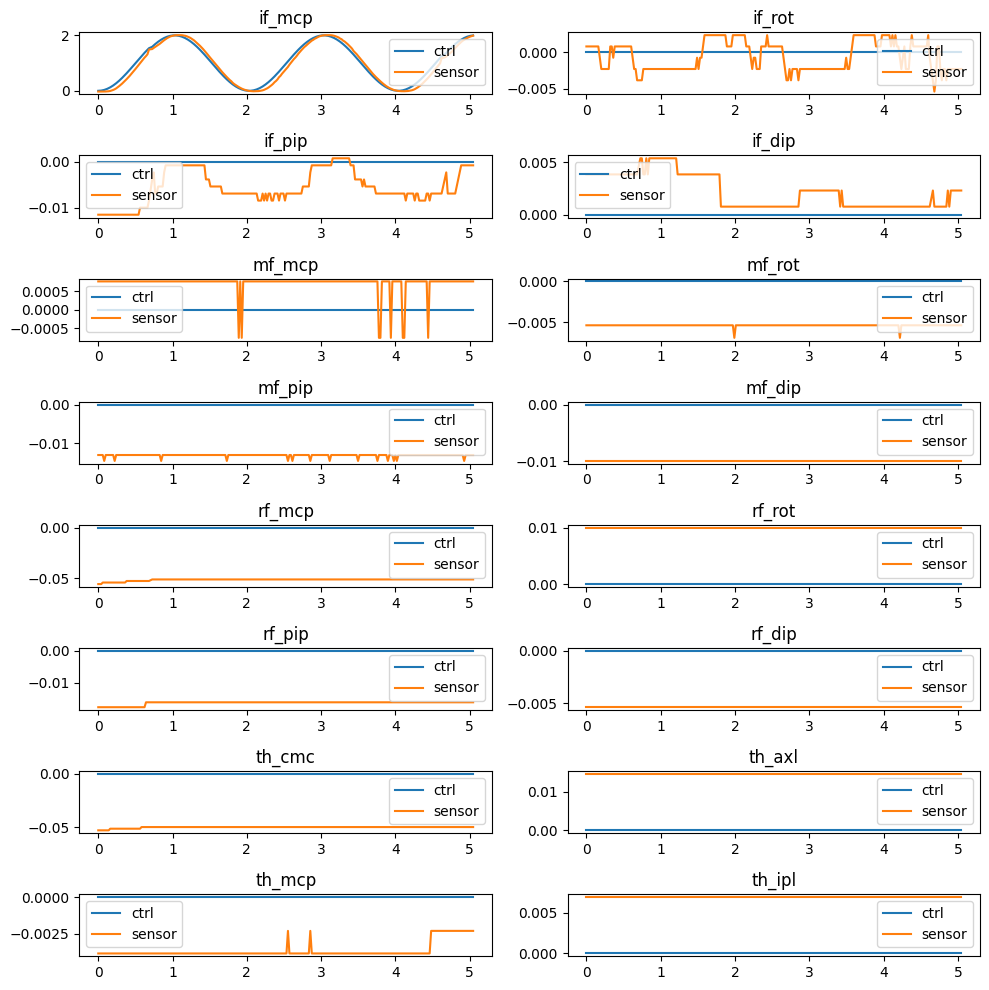

In [5]:
initial_state = sysid.create_initial_state(
    model, data.qpos, data.qvel, data.act
)
# Use zero-order hold so control is held between trajectory samples.
control_ts = sysid.TimeSeries(t, ctrl)
sensor_ts = sysid.TimeSeries.from_names(times, sensor, model)

# plot ctrl and sensor , each joint is a subplot and plot ctrl and sensor in the same subplot
fig, axes = plt.subplots(num_joints // 2,  2, figsize=(10, 10))
for i, joint_name in enumerate(joint_names):
    row = i // 2
    col = i % 2
    axes[row, col].plot(t, ctrl[:, i], label="ctrl")
    axes[row, col].plot(times, sensor[:, i], label="sensor")
    axes[row, col].set_title(joint_name)
    axes[row, col].legend()
plt.tight_layout()
plt.show()

state, _ = rollout.rollout(
    model, data, initial_state, 
    control_ts.resample(
        target_dt=model.opt.timestep, method="zoh"
    ).data,
)
state = np.squeeze(state, axis=0)
frames = sysid.render_rollout(
    model, data, state[None], framerate=30, height=400, width=560
)
media.show_video(frames, fps=30)

In [6]:
INIT_KP = 3.0
INIT_KV = -0.03

def make_armature_modifier(joint_name):
    """Create a modifier that sets armature on a specific joint."""
    def modifier(spec, param):
        spec.joint(joint_name).armature = param.value[0]
    return modifier

def make_joint_damping_modifier(joint_name):
    """Create a modifier that sets damping on a specific joint."""
    def modifier(spec, param):
        spec.joint(joint_name).damping = param.value[0]
    return modifier

def make_actuator_kp_modifier(actuator_name):
    """Create a modifier that sets gain on a specific actuator."""
    def modifier(spec, param):
        # print(f"Setting {actuator_name} kp to {param.value[0]}, originally {spec.actuator(actuator_name).gainprm[0]}")
        spec.actuator(actuator_name).gainprm[0] = param.value[0]
    return modifier

def make_actuator_kv_modifier(actuator_name):
    """Create a modifier that sets gain on a specific actuator."""
    def modifier(spec, param):
        # print(f"Setting {actuator_name} kv to {param.value[0]}, originally {spec.actuator(actuator_name).biasprm[2]}")
        spec.actuator(actuator_name).biasprm[2] = param.value[0]
    return modifier

params = sysid.ParameterDict()
transform = sysid.SignalTransform()
for name in joints_to_sysid:
    act_name = f"{name}_act"
    # get actuator actual kp and kv
    act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, act_name)
    true_kp = model.actuator_gainprm[act_id, 0]
    true_kv = model.actuator_biasprm[act_id, 2]
    params.add(sysid.Parameter(
        f"{name}_kp",
        nominal=true_kp,
        min_value=0.0,
        max_value=5.0,
        modifier=make_actuator_kp_modifier(act_name),
    ))
    params[f"{name}_kp"].value[:] = INIT_KP
    params.add(sysid.Parameter(
        f"{name}_kv",
        nominal=true_kv,
        min_value=-1.0,
        max_value=0.0,
        modifier=make_actuator_kv_modifier(act_name),
    ))
    params[f"{name}_kv"].value[:] = INIT_KV

    sensor_name = f"{name}_sensor"
    params.add(sysid.Parameter(
        f"{name}_delay_pos",
        nominal=0.0,
        min_value=0.0,
        max_value=0.1,
    ))
    transform.delay(sensor_name, params[f"{name}_delay_pos"])

transform.enable_sensors([f"{name}_sensor" for name in joints_to_sysid])

In [7]:
#@title { vertical-output: true}
ms = sysid.ModelSequences(
    "leap_hand", spec, "sinusoidal", initial_state, control_ts, sensor_ts,
)
residual_fn = sysid.build_residual_fn(
    models_sequences=[ms], 
    modify_residual=transform.apply)
opt_params, opt_result = sysid.optimize(
    initial_params=params,
    residual_fn=residual_fn,
    optimizer="mujoco",
)

iter: 0    y: 0.006679   log10mu: -inf  ratio: 0.99     dx: 0.04     reduction: 0.0061 
iter: 1    y: 0.0005405  log10mu: -2.0  ratio: 0.078    dx: 0.031    reduction: 1.5e-06
iter: 2    y: 0.000539   log10mu: -1.9  ratio: 0.85     dx: 0.01     reduction: 8.7e-06
iter: 3    y: 0.0005304  log10mu: -2.0  ratio: 0.44     dx: 0.0068   reduction: 4.9e-07
iter: 4    y: 0.0005299  log10mu: -2.0  ratio: 0.1      dx: 0.0037   reduction: 2.3e-08
iter: 5    y: 0.0005299  log10mu: -1.9  ratio: 0.34     dx: 0.0026   reduction: 5.1e-08
iter: 6    y: 0.0005298  log10mu: -1.9  ratio: 0.22     dx: 0.0015   reduction: 1e-08  
iter: 7    y: 0.0005298  log10mu: -1.8  ratio: 0.28     dx: 0.00094  reduction: 6.1e-09
iter: 8    y: 0.0005298  log10mu: -1.8  ratio: 0.37     dx: 0.00051  reduction: 2.3e-09
iter: 9    y: 0.0005298  log10mu: -1.8  ratio: 0.21     dx: 0.00026  reduction: 3.4e-10
iter: 10   y: 0.0005298  log10mu: -1.7  ratio: 0.29     dx: 0.00014  reduction: 1.6e-10
iter: 11   y: 0.0005298  log10mu

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper       | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=============+=============+=============+===========+===========+
| if_mcp_kp            |  3.0000     |  3.0000     |  3.0010      |  0.0000e+00 |  5.0000     |  1.0449e-03 |  1.0449e-03 | 0.0%      | 0.0%      |
| if_mcp_kv            | -0.0300     | -0.0300     | -0.0206      | -1.0000     |  0.0000e+00 |  9.4262e-03 |  9.4262e-03 | 31.4%     | 31.4%     |
| if_mcp_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0441      |  0.0000e+00 |  0.1000     |  0.0441     |  0.0441     |           |           |
+----------------------+-------------+-------------+--------------+-------------+-------------+------

iter: 14   y: 0.0005298  log10mu: -1.8  ratio: 1.3      dx: 6.7e-09  reduction: 3.5e-17
Terminated after 14 iterations: norm(dx) < tol. y: 0.0005298, Residual evals: 105
total time 9.0s of which residual 99.9%


In [8]:
report = sysid.default_report(
    models_sequences=[ms],
    initial_params=params,
    opt_params=opt_params,
    residual_fn=residual_fn,
    opt_result=opt_result,
    title="Leap Hand Identification",
    save_path=OUTPUT_DIR,
)
# display_report(report)

In [ ]:
INIT_KP = 3.0
INIT_KV = -0.03
INIT_ARMATURE = 0.0
INIT_FRICTIONLOSS = 0.0

def run_sysid(traj_data_path, save_dir):
    print(f"Loading model from {str(MJCF_PATH)}...")
    spec = mujoco.MjSpec.from_file(str(MJCF_PATH))
    model = spec.compile()
    data = mujoco.MjData(model)

    #------------
    # load the data
    #-------------
    joint_name = "if_mcp"
    path = traj_data_path
    with open(path, "rb") as f:
        traj_data = pickle.load(f)

    data_t = traj_data["t"]
    data_ctrl = traj_data["ctrl"]
    data_sensor_time = traj_data["sensor_time"]
    data_sensor = traj_data["sensor"]
    data_init_qpos = traj_data["init_qpos"]
    joints_to_sysid = traj_data["sys_id_joints"]
    spec_timestep = model.opt.timestep
    traj_timestep = traj_data["timestep"]
    print(f"Loaded {path} with {len(data_t)} timesteps, timestep={model.opt.timestep}")


    # -------------------
    # set correct indexing
    # ---------------------------
    joint_names = list(data_sensor.keys())
    num_joints = len(joint_names)

    # set init_qpos
    # init_qpos = np.zeros(num_joints)
    for joint_name in joint_names:
        joint_id = mujoco.mj_name2id(
            model, mujoco.mjtObj.mjOBJ_JOINT, joint_name
        )
        if joint_id == -1:
            raise ValueError(f"Joint {joint_name} not found in model")
        qpos_adr = model.jnt_qposadr[joint_id]
        data.qpos[qpos_adr] = data_init_qpos[joint_name]

    # set sensor
    sensor = np.zeros((len(data_sensor_time), num_joints))
    for joint_name in joint_names:
        sensor_id = mujoco.mj_name2id(
            model, mujoco.mjtObj.mjOBJ_SENSOR, f"{joint_name}_sensor"
        )
        if sensor_id == -1:
            raise ValueError(f"Sensor {joint_name}_sensor not found in model")
        sensor_adr = model.sensor_adr[sensor_id]
        sensor[:, sensor_adr] = data_sensor[joint_name]
    # check for bad values in sensor
    if np.any(np.isnan(sensor)) or np.any(np.isinf(sensor)):
        raise ValueError("Sensor data contains NaN or Inf values")

    # set ctrl
    ctrl = np.zeros((len(data_t), num_joints))
    for joint_name in joint_names:
        ctrl_id = mujoco.mj_name2id(
            model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"{joint_name}_act"
        )
        if ctrl_id == -1:
            raise ValueError(f"Actuator {joint_name}_actuator not found in model")
        if joint_name in data_ctrl:
            ctrl[:, ctrl_id] = data_ctrl[joint_name]
        else:
            ctrl[:, ctrl_id] = data_init_qpos[joint_name]
    # check for bad values in ctrl
    if np.any(np.isnan(ctrl)) or np.any(np.isinf(ctrl)):
        raise ValueError("Control data contains NaN or Inf values")

    # set qvel to 0
    data.qvel[:] = 0.0

    t = data_t
    times = data_sensor_time
    # check that t and times are strictly increasing
    assert np.all(np.diff(t) > 0), "t is not strictly increasing"
    assert np.all(np.diff(times) > 0), "times is not strictly increasing"

    mujoco.mj_forward(model, data)

    
    
    # ----------------
    # create states and time series
    # -----------------
    initial_state = sysid.create_initial_state(
        model, data.qpos, data.qvel, data.act
    )
    # Use zero-order hold so control is held between trajectory samples.
    control_ts = sysid.TimeSeries(t, ctrl)
    sensor_ts = sysid.TimeSeries.from_names(times, sensor, model)

    # -------------------
    # define modifiers
    # -------------------

    def make_armature_modifier(joint_name):
        """Create a modifier that sets armature on a specific joint."""
        def modifier(spec, param):
            spec.joint(joint_name).armature = param.value[0]
        return modifier

    def make_joint_damping_modifier(joint_name):
        """Create a modifier that sets damping on a specific joint."""
        def modifier(spec, param):
            spec.joint(joint_name).damping = param.value[0]
        return modifier

    def make_joint_frictionloss_modifier(joint_name):
        """Create a modifier that sets friction loss on a specific joint."""
        def modifier(spec, param):
            spec.joint(joint_name).frictionloss = param.value[0]
        return modifier

    def make_actuator_kp_modifier(actuator_name):
        """Create a modifier that sets gain on a specific actuator."""
        def modifier(spec, param):
            # print(f"Setting {actuator_name} kp to {param.value[0]}, originally {spec.actuator(actuator_name).gainprm[0]}")
            spec.actuator(actuator_name).gainprm[0] = param.value[0]
        return modifier

    def make_actuator_kv_modifier(actuator_name):
        """Create a modifier that sets gain on a specific actuator."""
        def modifier(spec, param):
            # print(f"Setting {actuator_name} kv to {param.value[0]}, originally {spec.actuator(actuator_name).biasprm[2]}")
            spec.actuator(actuator_name).biasprm[2] = param.value[0]
        return modifier

    params = sysid.ParameterDict()
    transform = sysid.SignalTransform()
    for name in joints_to_sysid:
        act_name = f"{name}_act"
        # get actuator actual kp and kv
        act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, act_name)
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        true_kp = model.actuator_gainprm[act_id, 0]
        true_kv = model.actuator_biasprm[act_id, 2]
        true_armature = model.joint(joint_id).armature
        true_frictionloss = model.joint(joint_id).frictionloss
        # params.add(sysid.Parameter(
        #     f"{name}_kp",
        #     nominal=true_kp,
        #     min_value=0.0,
        #     max_value=5.0,
        #     modifier=make_actuator_kp_modifier(act_name),
        # ))
        # params[f"{name}_kp"].value[:] = INIT_KP
        # params.add(sysid.Parameter(
        #     f"{name}_kv",
        #     nominal=true_kv,
        #     min_value=-1.0,
        #     max_value=0.0,
        #     modifier=make_actuator_kv_modifier(act_name),
        # ))
        # params[f"{name}_kv"].value[:] = INIT_KV
        # params.add(sysid.Parameter(
        #     f"{name}_armature",
        #     nominal=true_armature,
        #     min_value=0.0,
        #     max_value=1.0,
        #     modifier=make_armature_modifier(name),
        # ))
        # params[f"{name}_armature"].value[:] = INIT_ARMATURE

        params.add(sysid.Parameter(
            f"{name}_frictionloss",
            nominal=true_frictionloss,
            min_value=0.0,
            max_value=1.0,
            modifier=make_joint_frictionloss_modifier(name),
        ))
        params[f"{name}_frictionloss"].value[:] = INIT_FRICTIONLOSS

        sensor_name = f"{name}_sensor"
        params.add(sysid.Parameter(
            f"{name}_delay_pos",
            nominal=0.0,
            min_value=0.0,
            max_value=0.1,
        ))
        transform.delay(sensor_name, params[f"{name}_delay_pos"])

    transform.enable_sensors([f"{name}_sensor" for name in joints_to_sysid])

    # ---------------
    # run optimization
    # ----------------
    ms = sysid.ModelSequences(
        "leap_hand", spec, "sinusoidal", initial_state, control_ts, sensor_ts,
    )
    residual_fn = sysid.build_residual_fn(
        models_sequences=[ms], 
        modify_residual=transform.apply)
    opt_params, opt_result = sysid.optimize(
        initial_params=params,
        residual_fn=residual_fn,
        optimizer="mujoco",
    )
    report = sysid.default_report(
        models_sequences=[ms],
        initial_params=params,
        opt_params=opt_params,
        residual_fn=residual_fn,
        opt_result=opt_result,
        title="Leap Hand Identification",
        save_path=save_dir,
    )





In [10]:
traj_files = Path("outputs/traj").glob("*_trajectory.pkl")
for traj_file in traj_files:
    save_dir = OUTPUT_DIR / traj_file.stem
    run_sysid(traj_file, save_dir)

Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/mf_pip_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005789   log10mu: -inf  ratio: 1        dx: 0.036    reduction: 0.0057 
iter: 1    y: 9.584e-05  log10mu: -inf  ratio: 1        dx: 0.00027  reduction: 3.1e-07
iter: 2    y: 9.552e-05  log10mu: -inf  ratio: 1        dx: 2.6e-06  reduction: 2.8e-11


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| mf_pip_armature      |  0.0000e+00 |  0.0000e+00 |  0.0000e+00  |  0.0000e+00 |  1.0000 |  0.0000e+00 |  0.0000e+00 |           |           |
| mf_pip_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0368      |  0.0000e+00 |  0.1000 |  0.0368     |  0.0368     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02599
RMS Delta: 0.02599


Terminated after 3 iterations: norm(gradient) < tol. y: 9.552e-05, Residual evals: 14
total time 1.2s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/if_dip_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005387   log10mu: -inf  ratio: 1        dx: 0.039    reduction: 0.0053 
iter: 1    y: 4.242e-05  log10mu: -inf  ratio: 1        dx: 0.00037  reduction: 5.5e-07
iter: 2    y: 4.187e-05  log10mu: -inf  ratio: 1        dx: 1.4e-05  reduction: 7.5e-10
iter: 3    y: 4.187e-05  log10mu: -inf  ratio: 1        dx: 5.3e-07  reduction: 1.1e-12
iter: 4    y: 4.187e-05  log10mu: -inf  ratio: 1        dx: 2.1e-08  reduction: 1.7e-15


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| if_dip_armature      |  0.0000e+00 |  0.0000e+00 |  4.7598e-04  |  0.0000e+00 |  1.0000 |  4.7598e-04 |  4.7598e-04 |           |           |
| if_dip_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0388      |  0.0000e+00 |  0.1000 |  0.0388     |  0.0388     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02743
RMS Delta: 0.02743


Terminated after 5 iterations: norm(gradient) < tol. y: 4.187e-05, Residual evals: 20
total time 1.6s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/th_ipl_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.007283   log10mu: -inf  ratio: 1        dx: 0.034    reduction: 0.0071 
iter: 1    y: 0.0001606  log10mu:  2.9  ratio: 0.042    dx: 1.8e-05  reduction: 1.1e-08
iter: 2    y: 0.0001606  log10mu:  3.0  ratio: 0.45     dx: 1.6e-05  reduction: 1.1e-07
iter: 3    y: 0.0001605  log10mu:  3.0  ratio: 0.16     dx: 1.2e-05  reduction: 2.5e-08
iter: 4    y: 0.0001605  log10mu:  3.1  ratio: 0.76     dx: 8.9e-06  reduction: 7.7e-08
iter: 5    y: 0.0001604  log10mu:  3.0  ratio: 0.25     dx: 7.4e-06  reduction: 1.4e-08
iter: 6    y: 0.0001604  log10mu:  3.0  ratio: 0.19     dx: 1.2e-05  reduction: 3e-08  
iter: 7    y: 0.0001604  log10mu:  3.1  ratio: 0.75     dx: 8.8e-06  reduction: 7.4e-08
iter: 8    y: 0.0001603  log10mu: 

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| th_ipl_armature      |  0.0000e+00 |  0.0000e+00 |  3.0992e-06  |  0.0000e+00 |  1.0000 |  3.0992e-06 |  3.0992e-06 |           |           |
| th_ipl_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0348      |  0.0000e+00 |  0.1000 |  0.0348     |  0.0348     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02463
RMS Delta: 0.02463


iter: 199  y: 0.0001588  log10mu:  3.4  ratio: 0.022    dx: 2.3e-06  reduction: 3e-10  
Terminated after 199 iterations: maximum iterations reached. y: 0.0001588, Residual evals: 796
total time 68.8s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/if_rot_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.02115    log10mu: -inf  ratio: 1        dx: 0.047    reduction: 0.021  
iter: 1    y: 0.0002575  log10mu: -inf  ratio: 1        dx: 0.00084  reduction: 6.5e-06
iter: 2    y: 0.000251   log10mu: -inf  ratio: 1        dx: 3.8e-06  reduction: 1.3e-10


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| if_rot_armature      |  0.0000e+00 |  0.0000e+00 |  0.0000e+00  |  0.0000e+00 |  1.0000 |  0.0000e+00 |  0.0000e+00 |           |           |
| if_rot_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0476      |  0.0000e+00 |  0.1000 |  0.0476     |  0.0476     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.03368
RMS Delta: 0.03368


Terminated after 3 iterations: norm(gradient) < tol. y: 0.000251, Residual evals: 14
total time 1.1s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/rf_rot_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.02426    log10mu: -inf  ratio: 1        dx: 0.05     reduction: 0.024  
iter: 1    y: 0.0002671  log10mu: -inf  ratio: 1        dx: 0.00095  reduction: 8.5e-06
iter: 2    y: 0.0002586  log10mu: -inf  ratio: 0.97     dx: 1.4e-05  reduction: 1.7e-09
iter: 3    y: 0.0002586  log10mu: -inf  ratio: 1        dx: 3e-07    reduction: 8.1e-13


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| rf_rot_armature      |  0.0000e+00 |  0.0000e+00 |  0.0000e+00  |  0.0000e+00 |  1.0000 |  0.0000e+00 |  0.0000e+00 |           |           |
| rf_rot_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0509      |  0.0000e+00 |  0.1000 |  0.0509     |  0.0509     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.036
RMS Delta: 0.036


Terminated after 4 iterations: norm(gradient) < tol. y: 0.0002586, Residual evals: 17
total time 1.4s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/rf_dip_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.004431   log10mu: -inf  ratio: 1        dx: 0.035    reduction: 0.0044 
iter: 1    y: 2.539e-05  log10mu: -inf  ratio: 1        dx: 0.00019  reduction: 1.4e-07
iter: 2    y: 2.524e-05  log10mu: -inf  ratio: 1        dx: 8.3e-06  reduction: 2.6e-10
iter: 3    y: 2.524e-05  log10mu: -inf  ratio: 1        dx: 3.7e-07  reduction: 5.1e-13
iter: 4    y: 2.524e-05  log10mu: -inf  ratio: 1        dx: 1.6e-08  reduction: 9.1e-16


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| rf_dip_armature      |  0.0000e+00 |  0.0000e+00 |  2.6371e-04  |  0.0000e+00 |  1.0000 |  2.6371e-04 |  2.6371e-04 |           |           |
| rf_dip_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0352      |  0.0000e+00 |  0.1000 |  0.0352     |  0.0352     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02492
RMS Delta: 0.02492


Terminated after 5 iterations: norm(gradient) < tol. y: 2.524e-05, Residual evals: 20
total time 1.6s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/if_mcp_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.006679   log10mu: -inf  ratio: 0.99     dx: 0.041    reduction: 0.0061 
iter: 1    y: 0.0005324  log10mu: -inf  ratio: 1.7      dx: 0.0014   reduction: 5e-05  
iter: 2    y: 0.000482   log10mu: -inf  ratio: 1.9      dx: 0.00072  reduction: 2.5e-05
iter: 3    y: 0.0004569  log10mu: -inf  ratio: 1.7      dx: 0.00062  reduction: 1.7e-05
iter: 4    y: 0.0004403  log10mu: -inf  ratio: 1.6      dx: 0.00041  reduction: 6.6e-06
iter: 5    y: 0.0004338  log10mu: -inf  ratio: 1.6      dx: 0.00025  reduction: 2.5e-06
iter: 6    y: 0.0004313  log10mu: -inf  ratio: 1.7      dx: 0.00017  reduction: 1.2e-06
iter: 7    y: 0.0004301  log10mu: -inf  ratio: 1.8      dx: 0.00013  reduction: 6.7e-07
iter: 8    y: 0.0004295  log10mu: 

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| if_mcp_armature      |  0.0000e+00 |  0.0000e+00 |  4.8926e-03  |  0.0000e+00 |  1.0000 |  4.8926e-03 |  4.8926e-03 |           |           |
| if_mcp_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0404      |  0.0000e+00 |  0.1000 |  0.0404     |  0.0404     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02878
RMS Delta: 0.02878


iter: 49   y: 0.0004259  log10mu:  2.9  ratio: 0.093    dx: 2.3e-10  reduction: 4.1e-18
Terminated after 49 iterations: norm(dx) < tol. y: 0.0004259, Residual evals: 243
total time 21.9s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/th_cmc_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.008363   log10mu: -inf  ratio: 1        dx: 0.047    reduction: 0.0081 
iter: 1    y: 0.0002631  log10mu: -inf  ratio: 1.4      dx: 0.002    reduction: 3e-05  
iter: 2    y: 0.0002327  log10mu: -inf  ratio: 1.3      dx: 0.0009   reduction: 4.9e-06
iter: 3    y: 0.0002277  log10mu: -inf  ratio: 1.1      dx: 0.00021  reduction: 2.2e-07
iter: 4    y: 0.0002275  log10mu: -inf  ratio: 1        dx: 1.6e-05  reduction: 1.2e-09
iter: 5    y: 0.0002275  log10mu: -inf  ratio: 1        dx: 7.5e-07  reduction: 2.7e-12
iter: 6    y: 0.0002275  log10mu: -inf  ratio: 1        dx: 3.4e-08  reduction: 5.4e-15
iter: 7    y: 0.0002275  log10mu: -in

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| th_cmc_armature      |  0.0000e+00 |  0.0000e+00 |  3.1039e-03  |  0.0000e+00 |  1.0000 |  3.1039e-03 |  3.1039e-03 |           |           |
| th_cmc_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0467      |  0.0000e+00 |  0.1000 |  0.0467     |  0.0467     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.03308
RMS Delta: 0.03308


Terminated after 8 iterations: norm(gradient) < tol. y: 0.0002275, Residual evals: 29
total time 2.3s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/th_axl_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005408   log10mu: -inf  ratio: 1        dx: 0.034    reduction: 0.0053 
iter: 1    y: 0.0001319  log10mu: -inf  ratio: 1.2      dx: 0.00024  reduction: 7.4e-07
iter: 2    y: 0.0001312  log10mu: -inf  ratio: 1.3      dx: 5.4e-05  reduction: 4.7e-08
iter: 3    y: 0.0001311  log10mu: -inf  ratio: 1.4      dx: 1.7e-05  reduction: 5.3e-09
iter: 4    y: 0.0001311  log10mu: -inf  ratio: 1.4      dx: 6.4e-06  reduction: 7.4e-10
iter: 5    y: 0.0001311  log10mu: -inf  ratio: 1.4      dx: 2.5e-06  reduction: 1.1e-10
iter: 6    y: 0.0001311  log10mu: -inf  ratio: 1.4      dx: 9.5e-07  reduction: 1.6e-11
iter: 7    y: 0.0001311  log10mu: -inf  ratio: 1.4      dx: 3.7e-07  reduction: 2.4e-12
iter: 8    y: 0.0001311  log10mu: 

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| th_axl_armature      |  0.0000e+00 |  0.0000e+00 |  4.1487e-04  |  0.0000e+00 |  1.0000 |  4.1487e-04 |  4.1487e-04 |           |           |
| th_axl_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0340      |  0.0000e+00 |  0.1000 |  0.0340     |  0.0340     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02405
RMS Delta: 0.02405


Terminated after 13 iterations: insufficient reduction. y: 0.0001311, Residual evals: 185
total time 19.0s of which residual 100.0%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/mf_dip_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.004368   log10mu: -inf  ratio: 1        dx: 0.035    reduction: 0.0043 
iter: 1    y: 5.704e-05  log10mu: -inf  ratio: 1.2      dx: 0.00036  reduction: 8.1e-07
iter: 2    y: 5.623e-05  log10mu: -inf  ratio: 1.5      dx: 5.2e-05  reduction: 2.9e-08
iter: 3    y: 5.62e-05   log10mu: -inf  ratio: 1.5      dx: 2.3e-05  reduction: 5.8e-09
iter: 4    y: 5.619e-05  log10mu: -inf  ratio: 1.4      dx: 1e-05    reduction: 1.1e-09
iter: 5    y: 5.619e-05  log10mu: -inf  ratio: 1.4      dx: 4.5e-06  reduction: 2.3e-10
iter: 6    y: 5.619e-05  log10mu: -inf  ratio: 1.4      dx: 2e-06    reduction: 4.5e-11
iter: 7    y: 5.619e-05  log10mu: -inf  ratio: 1.4      dx: 8.9e-07  reduction: 9e-12  
iter: 8    y: 5.619e-05  log

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| mf_dip_armature      |  0.0000e+00 |  0.0000e+00 |  5.6884e-04  |  0.0000e+00 |  1.0000 |  5.6884e-04 |  5.6884e-04 |           |           |
| mf_dip_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0349      |  0.0000e+00 |  0.1000 |  0.0349     |  0.0349     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.0247
RMS Delta: 0.0247


iter: 14   y: 5.619e-05  log10mu:  2.9  ratio: 0.066    dx: 6.2e-11  reduction: 2e-19  
Terminated after 14 iterations: norm(dx) < tol. y: 5.619e-05, Residual evals: 138
total time 13.6s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/mf_mcp_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005861   log10mu: -inf  ratio: 1        dx: 0.039    reduction: 0.0056 
iter: 1    y: 0.0002293  log10mu: -inf  ratio: 1        dx: 0.00055  reduction: 1.1e-06
iter: 2    y: 0.0002281  log10mu: -inf  ratio: 1.1      dx: 3.1e-06  reduction: 3.9e-11
iter: 3    y: 0.0002281  log10mu: -inf  ratio: 1        dx: 6.9e-07  reduction: 1.8e-12


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| mf_mcp_armature      |  0.0000e+00 |  0.0000e+00 |  0.0000e+00  |  0.0000e+00 |  1.0000 |  0.0000e+00 |  0.0000e+00 |           |           |
| mf_mcp_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0393      |  0.0000e+00 |  0.1000 |  0.0393     |  0.0393     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.0278
RMS Delta: 0.0278


Terminated after 4 iterations: norm(gradient) < tol. y: 0.0002281, Residual evals: 17
total time 1.3s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/mf_rot_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.02174    log10mu: -inf  ratio: 1        dx: 0.047    reduction: 0.022  
iter: 1    y: 0.0002287  log10mu: -inf  ratio: 1        dx: 0.00083  reduction: 6.4e-06
iter: 2    y: 0.0002223  log10mu: -inf  ratio: 0.99     dx: 4.3e-06  reduction: 1.7e-10
iter: 3    y: 0.0002223  log10mu: -inf  ratio: 1        dx: 1.3e-07  reduction: 1.7e-13


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| mf_rot_armature      |  0.0000e+00 |  0.0000e+00 |  0.0000e+00  |  0.0000e+00 |  1.0000 |  0.0000e+00 |  0.0000e+00 |           |           |
| mf_rot_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0482      |  0.0000e+00 |  0.1000 |  0.0482     |  0.0482     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.03407
RMS Delta: 0.03407


Terminated after 4 iterations: norm(gradient) < tol. y: 0.0002223, Residual evals: 17
total time 1.3s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/rf_pip_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005644   log10mu: -inf  ratio: 1        dx: 0.036    reduction: 0.0055 
iter: 1    y: 0.0001212  log10mu: -inf  ratio: 1        dx: 0.00042  reduction: 7.3e-07
iter: 2    y: 0.0001205  log10mu: -inf  ratio: 1        dx: 2e-06    reduction: 1.7e-11


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| rf_pip_armature      |  0.0000e+00 |  0.0000e+00 |  0.0000e+00  |  0.0000e+00 |  1.0000 |  0.0000e+00 |  0.0000e+00 |           |           |
| rf_pip_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0364      |  0.0000e+00 |  0.1000 |  0.0364     |  0.0364     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02571
RMS Delta: 0.02571


Terminated after 3 iterations: norm(gradient) < tol. y: 0.0001205, Residual evals: 14
total time 1.1s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/if_pip_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005863   log10mu: -inf  ratio: 1        dx: 0.036    reduction: 0.0057 
iter: 1    y: 0.0002034  log10mu: -inf  ratio: 1        dx: 0.00039  reduction: 6.6e-07
iter: 2    y: 0.0002028  log10mu: -inf  ratio: 1        dx: 3.6e-06  reduction: 5.6e-11


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| if_pip_armature      |  0.0000e+00 |  0.0000e+00 |  0.0000e+00  |  0.0000e+00 |  1.0000 |  0.0000e+00 |  0.0000e+00 |           |           |
| if_pip_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0366      |  0.0000e+00 |  0.1000 |  0.0366     |  0.0366     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02589
RMS Delta: 0.02589


Terminated after 3 iterations: norm(gradient) < tol. y: 0.0002028, Residual evals: 14
total time 1.1s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/th_mcp_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005775   log10mu: -inf  ratio: 1        dx: 0.032    reduction: 0.0057 
iter: 1    y: 0.0001097  log10mu: -inf  ratio: 0.52     dx: 0.00035  reduction: 1.9e-06
iter: 2    y: 0.0001079  log10mu: -inf  ratio: 0.89     dx: 7.3e-05  reduction: 9.1e-08
iter: 3    y: 0.0001078  log10mu: -inf  ratio: 0.87     dx: 8.4e-06  reduction: 9.2e-10
iter: 4    y: 0.0001078  log10mu: -inf  ratio: 0.78     dx: 1.1e-06  reduction: 1.7e-11
iter: 5    y: 0.0001078  log10mu: -inf  ratio: 0.99     dx: 2.7e-07  reduction: 1.3e-12
iter: 6    y: 0.0001078  log10mu: -inf  ratio: 0.77     dx: 1.8e-08  reduction: 2.5e-15
iter: 7    y: 0.0001078  log10mu: -inf  ratio: 2        dx: 1.7e-09  reduction: 9.8e-17


INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| th_mcp_armature      |  0.0000e+00 |  0.0000e+00 |  2.7632e-04  |  0.0000e+00 |  1.0000 |  2.7632e-04 |  2.7632e-04 |           |           |
| th_mcp_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0318      |  0.0000e+00 |  0.1000 |  0.0318     |  0.0318     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02249
RMS Delta: 0.02249


Terminated after 8 iterations: norm(gradient) < tol. y: 0.0001078, Residual evals: 29
total time 2.3s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/full_trajectory.pkl with 500 timesteps, timestep=0.002
iter: 0    y: 0.1135     log10mu: -inf  ratio: 1        dx: 0.16     reduction: 0.11   
iter: 1    y: 0.004809   log10mu: -inf  ratio: 1        dx: 0.0036   reduction: 5.7e-05
iter: 2    y: 0.004751   log10mu: -inf  ratio: 0.071    dx: 0.00059  reduction: 2.5e-06
iter: 3    y: 0.004749   log10mu: -6.0  ratio: 0.33     dx: 0.00061  reduction: 3e-06  
iter: 4    y: 0.004746   log10mu:  2.7  ratio: 0.016    dx: 0.00018  reduction: 4.3e-07
iter: 5    y: 0.004745   log10mu:  2.8  ratio: 0.55     dx: 3.3e-05  reduction: 3.7e-07
iter: 6    y: 0.004745   log10mu:  2.8  ratio: 0.062    dx: 6.4e-05  reduction: 2.6e-07
iter: 7    y: 0.004745   log10mu:  2.9  ratio: 0.98     dx: 2.2e-05  reduction: 3.6e-07
iter: 8    y: 0.004744   log10mu:  2

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| if_mcp_armature      |  0.0000e+00 |  0.0000e+00 |  1.4706e-03  |  0.0000e+00 |  1.0000 |  1.4706e-03 |  1.4706e-03 |           |           |
| if_mcp_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0519      |  0.0000e+00 |  0.1000 |  0.0519     |  0.0519     |           |           |
| if_pip_armature      |  0.0000e+00 |  0.0000e+00 |  2.4290e-04  |  0.0000e+00 |  1.0000 |  2.4290e-04 |  2.4290e-04 |           |           |
| if_pip_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0402      |  0.0000e+00 |  0.1000 |  0.0402     |  0.0402     |      

Terminated after 199 iterations: maximum iterations reached. y: 0.004742, Residual evals: 5552
total time 203.1s of which residual 99.9%
Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/rf_mcp_trajectory.pkl with 250 timesteps, timestep=0.002
iter: 0    y: 0.005437   log10mu: -inf  ratio: 1        dx: 0.037    reduction: 0.0051 
iter: 1    y: 0.0003815  log10mu: -inf  ratio: 1.5      dx: 0.0018   reduction: 2.8e-05
iter: 2    y: 0.0003535  log10mu: -inf  ratio: 1.3      dx: 0.00089  reduction: 6e-06  
iter: 3    y: 0.0003475  log10mu: -inf  ratio: 1.1      dx: 0.00027  reduction: 4.5e-07
iter: 4    y: 0.000347   log10mu: -inf  ratio: 1.1      dx: 4e-05    reduction: 9.3e-09
iter: 5    y: 0.000347   log10mu: -inf  ratio: 1.1      dx: 4.6e-06  reduction: 1.2e-10
iter: 6    y: 0.000347   log10mu: -inf  ratio: 1.1      dx: 5.2e-07  reduction: 1.6e-12
iter: 7    y: 0.000347   log10mu: -inf  ratio: 1.1      dx: 5.9e-08  reduction: 1.9e-14
iter: 8    y: 0.000347 

INFO:absl:
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
| Parameter            | Initial     | Nominal     | Identified   | Lower       | Upper   | Abs Err     | Abs Del     | Rel Err   | Rel Del   |
+======================+=============+=============+==============+=============+=========+=============+=============+===========+===========+
| rf_mcp_armature      |  0.0000e+00 |  0.0000e+00 |  3.1859e-03  |  0.0000e+00 |  1.0000 |  3.1859e-03 |  3.1859e-03 |           |           |
| rf_mcp_delay_pos     |  0.0000e+00 |  0.0000e+00 |  0.0362      |  0.0000e+00 |  0.1000 |  0.0362     |  0.0362     |           |           |
+----------------------+-------------+-------------+--------------+-------------+---------+-------------+-------------+-----------+-----------+
RMSE: 0.02572
RMS Delta: 0.02572


Terminated after 9 iterations: norm(gradient) < tol. y: 0.000347, Residual evals: 32
total time 2.6s of which residual 99.9%
